# A Lightweight Concept Drift Detection and Adaptation Framework for IoT Data Streams
This code is primarily based on the framework described in the paper titled "A Lightweight Concept Drift Detection and Adaptation Framework for IoT Data Streams," which was accepted in IEEE Internet of Things Magazine. The paper was authored by Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca) from the Optimized Computing and Communications (OC2) Lab, ECE Department, Western University.

This implementation draws on the concepts and methodologies discussed in the paper, focusing on real-time concept drift detection and model adaptation for IoT data streams using sliding windows and threshold-based drift identification.



## Import libraries

In [21]:
!pip install river
!pip install memory_profiler

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from river import metrics
from river import stream
import matplotlib.pyplot as plt
import seaborn as sns
import time
from google.colab import drive
import os

## Read the NSL-KDD dataset

In [23]:
drive.mount('/content/drive/')
# Change the working directory
os.chdir('/content/drive/MyDrive/drift-detection/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [24]:
df = pd.read_csv("NSL_KDD_binary(train+test).csv")
df1 = pd.read_csv("NSL_KDD_binary_train.csv")
df2 = pd.read_csv("NSL_KDD_binary_test.csv")

### Data sampling
Use the last 10% of training set and the entire test set

In [25]:
df_used = int(len(df1)*0.1) + len(df2)
df0 = df.iloc[-df_used:]


In [26]:
df0

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
113376,0,1,54,9,1132,366,0,0,0,0,...,148,0.88,0.08,0.03,0.01,0.00,0.0,0.00,0.00,0
113377,0,1,24,9,256,3123,0,0,0,0,...,255,1.00,0.00,0.01,0.02,0.00,0.0,0.00,0.00,0
113378,1,1,54,9,2215,333,0,0,0,0,...,99,0.39,0.08,0.00,0.00,0.02,0.0,0.00,0.00,0
113379,0,1,5,5,0,0,0,0,0,0,...,1,0.00,0.07,0.00,0.00,1.00,1.0,0.00,0.00,1
113380,0,1,56,5,0,0,0,0,0,0,...,1,0.00,0.08,0.00,0.00,1.00,1.0,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,1,49,9,794,333,0,0,0,0,...,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,0
148513,0,1,22,9,317,938,0,0,0,0,...,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,0
148514,0,1,22,9,54540,8314,0,0,0,2,...,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,1
148515,0,2,11,9,42,42,0,0,0,0,...,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,0


## Train-test split
10% training set, and 90% test set

In [27]:
X = df0.drop(['label'],axis=1)
y = df0['label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.1, test_size = 0.9, shuffle=False, random_state = 0)

[LightGBM] [Info] Number of positive: 1599, number of negative: 1915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2049
[LightGBM] [Info] Number of data points in the train set: 3514, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.455037 -> initscore=-0.180339
[LightGBM] [Info] Start training from score -0.180339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1599, number of negative: 1915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


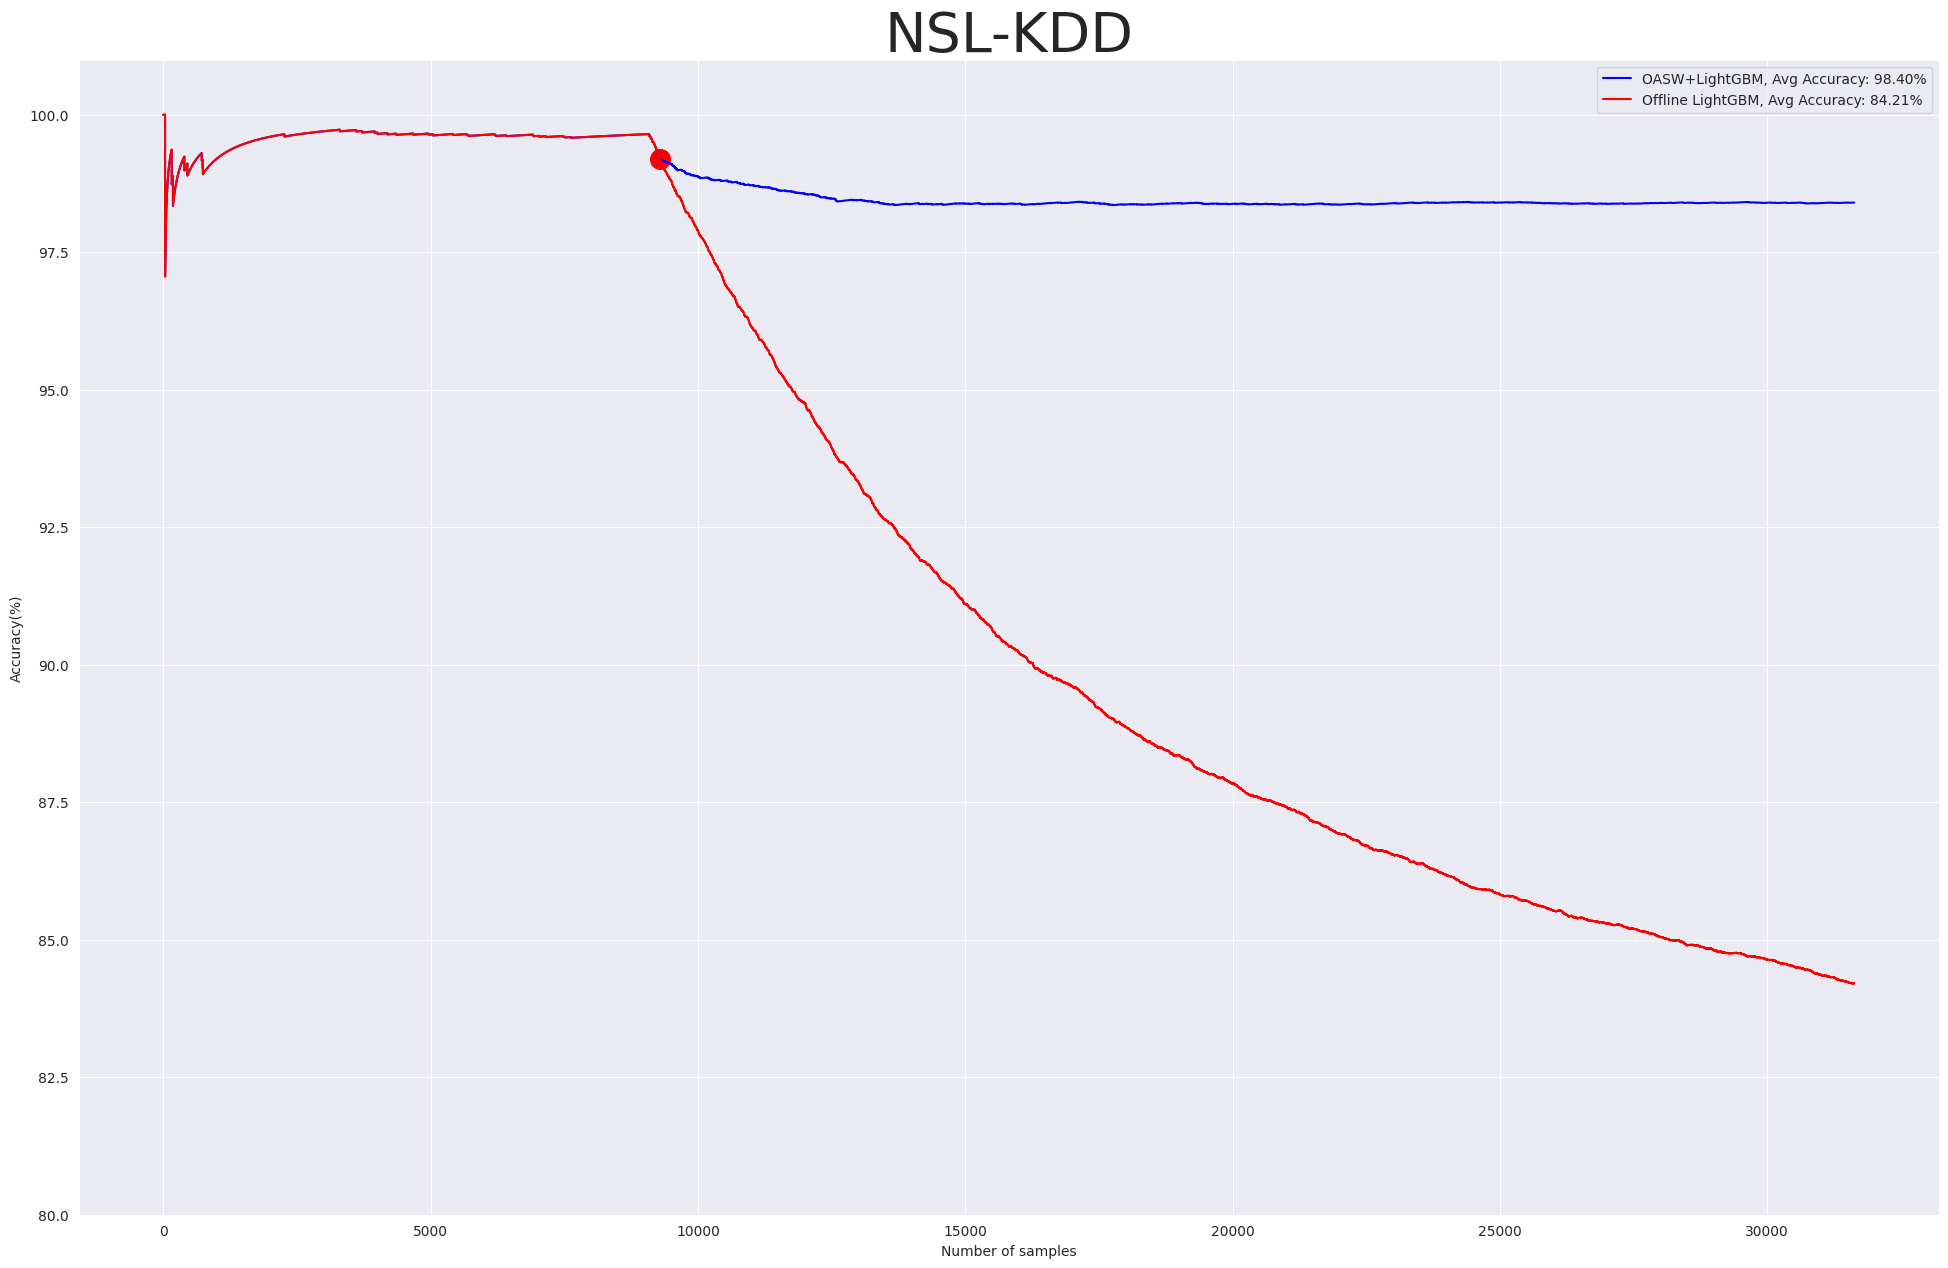

In [39]:
def drift_plot(X_train, y_train, X_test, y_test, a=0.99, b=0.95, win1=200, win2=1000):
    a = round(a, 3)
    b = round(b, 3)
    win1 = round(win1)
    win2 = round(win2)

    metric = metrics.Accuracy()
    metric2 = metrics.Accuracy()

    i = 0
    t = []
    yt = []
    yp = []
    m = []
    m2 = []
    x_new = []
    y_new = []
    dr = [0]
    d = 0
    f = 0
    tt = 0
    th = 0
    xt = []

    classifier = lgb.LGBMClassifier()
    classifier.fit(X_train, y_train)

    classifier2 = lgb.LGBMClassifier()
    classifier2.fit(X_train, y_train)

    for xi, yi in zip(X_test.iterrows(), y_test):
        xi2 = np.array(list(xi[1].values))
        y_pred = classifier.predict(xi2.reshape(1, -1))[0]
        y_pred_scalar = y_pred.item() if isinstance(y_pred, np.ndarray) else y_pred
        yi_scalar = yi.item() if isinstance(yi, np.ndarray) else yi

        metric.update(yi_scalar, y_pred_scalar)
        current_metric = metric.get()

        y_pred2 = classifier2.predict(xi2.reshape(1, -1))[0]
        y_pred2_scalar = y_pred2.item() if isinstance(y_pred2, np.ndarray) else y_pred2
        metric2.update(yi_scalar, y_pred2_scalar)
        current_metric2 = metric2.get()

        t.append(i)
        m.append(current_metric * 100)
        yt.append(yi_scalar)
        yp.append(y_pred_scalar)
        m2.append(current_metric2 * 100)
        xt.append(xi2)

        if i > 2 * win1:
            acc1 = accuracy_score(yt[i-win1:], yp[i-win1:])
            acc2 = accuracy_score(yt[i-2*win1:i-win1], yp[i-2*win1:i-win1])
            if (d == 0) and (acc1 < a * acc2):
                x_new.append(xi2)
                y_new.append(yi_scalar)
                d = 1
            if d == 1:
                tt = len(y_new)
                if acc1 < b * acc2:
                    dr.append(i)
                    f = i
                    if tt < win1:
                        classifier.fit(xt[i-win1:], yt[i-win1:])
                    else:
                        classifier.fit(x_new, y_new)
                    d = 2
                elif (acc1 > a * acc2) or (tt == win2):
                    x_new = []
                    y_new = []
                    d = 0
                else:
                    x_new.append(xi2)
                    y_new.append(yi_scalar)

            if d == 2:
                tt = len(y_new)
                acc3 = accuracy_score(yt[f:f+win1], yp[f:f+win1])
                x_new.append(xi2)
                y_new.append(yi_scalar)
                if tt >= win1:
                    if (acc1 < a * acc3):
                        if th == 0:
                            classifier.fit(x_new, y_new)
                            th = 1
                    if (th == 1) and (tt == win2):
                        classifier.fit(x_new, y_new)
                        x_new = []
                        y_new = []
                        d = 0
                        th = 0

        i += 1

    plt.figure(figsize=(24, 15))
    sns.set_style("darkgrid")
    plt.plot(t, m, '-b', label=f'OASW+LightGBM, Avg Accuracy: {metric.get()*100:.2f}%')
    plt.plot(t, m2, 'red', label=f'Offline LightGBM, Avg Accuracy: {metric2.get()*100:.2f}%')

    for i in range(1, len(dr)):
        plt.scatter(dr[i], m[dr[i]], s=200, c='r')

    plt.legend(loc='best')
    plt.ylim(80, 101)
    plt.title('NSL-KDD', fontsize=40)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy(%)')
    plt.show()

# Usage example:
drift_plot(X_train, y_train, X_test, y_test, a=0.978, b=0.931, win1=611, win2=4320)